# 5. ADI forward modeling of point sources

> Authors: *Valentin Christiaens* and *Carlos Alberto Gomez Gonzalez*  
> Suitable for VIP *v1.0.0* onwards  
> Last update: *2022/09/21*

**Table of contents**

* [5.1. Loading ADI data](#1.-Loading-ADI-data)

* [5.2. Generating and injecting synthetic planets](#5.2.-Generating-and-injecting-synthetic-planets)
 
* [5.3. Flux and position estimation with NEGFC](#5.3.-Flux-and-position-estimation-with-NEGFC)
    - [5.3.1. Nelder-Mead based optimization](#5.3.1.-Nelder-Mead-based-optimization)
    - [5.3.2. Planet subtraction](#5.3.2.-Planet-subtraction)
    - [5.3.3. NEGFC technique coupled with MCMC](#5.3.3.-NEGFC-technique-coupled-with-MCMC)
        - [5.3.3.1. Running the MCMC sampler](#5.3.3.1.-Running-the-MCMC-sampler)
        - [5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots](#5.3.3.2.-Visualizing-the-MCMC-chain:-corner-plots-and-walk-plots)
        - [5.3.3.3. Highly probable values and confidence intervals](#5.3.3.3.-Highly-probable-values-and-confidence-intervals)
    - [5.3.4. Residual speckle uncertainty](#5.3.4.-Residual-speckle-uncertainty)
    - [5.3.5. Final uncertainties](#5.3.5.-Final-uncertainties)

This tutorial shows:

- how to generate and inject fake companions in a cube;
- how to estimate the astrometry and photometry of a directly imaged companion, and associated uncertainties.

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In the following box we import all the VIP routines that will be used in this tutorial.
The path to some routines has changed between versions 1.0.3 and 1.1.0, which saw a major revamp of the modular architecture, hence the `if` statements.

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.conf import VLT_NACO
    from vip_hci.metrics import cube_inject_companions
    from vip_hci.negfc import (confidence, firstguess, mcmc_negfc_sampling, show_corner_plot, show_walk_plot,
                               speckle_noise_uncertainty)
    from vip_hci.pca import pca, pca_annular, pca_annulus, pca_grid
else:
    from vip_hci.config import VLT_NACO
    from vip_hci.fm import (confidence, cube_inject_companions, cube_planet_free, firstguess, mcmc_negfc_sampling, 
                            normalize_psf, show_corner_plot, show_walk_plot, speckle_noise_uncertainty)
    from vip_hci.psfsub import median_sub, pca, pca_annular, pca_annulus, pca_grid
    
# common to all versions:
from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.metrics import contrast_curve, detection, significance, snr, snrmap, throughput
from vip_hci.preproc import frame_crop
from vip_hci.var import fit_2dgaussian, frame_center

VIP version:  1.3.6


## 5.1. Loading ADI data

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO  dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract) obtained using the Annular Groove Phase Mask (AGPM) Vortex coronagraph. The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

Let's load the data:

In [3]:
psfnaco = '../datasets/naco_betapic_psf.fits'
cubename = '../datasets/naco_betapic_cube_cen.fits'
angname = '../datasets/naco_betapic_pa.fits'

cube = open_fits(cubename)
psf = open_fits(psfnaco)
pa = open_fits(angname)

Fits HDU-0 data successfully loaded. Data shape: (61, 101, 101)
Fits HDU-0 data successfully loaded. Data shape: (39, 39)
Fits HDU-0 data successfully loaded. Data shape: (61,)


In [4]:
derot_off = 104.84 # NACO derotator offset for this observation (Absil et al. 2013)
TN = -0.45         # Position angle of true north for NACO at the epoch of observation (Absil et al. 2013)

angs = pa+derot_off+TN

Let's measure the FWHM by fitting a 2D Gaussian to the core of the unsaturated non-coronagraphic PSF:

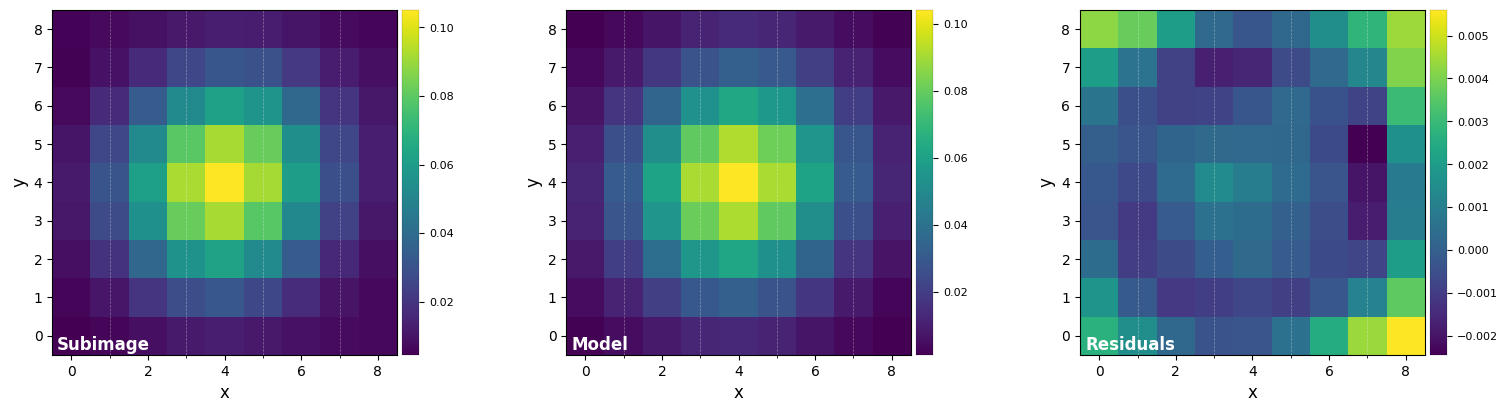

FWHM_y = 4.733218722257407
FWHM_x = 4.473682405059958 

centroid y = 19.006680059041216
centroid x = 18.999424475165455
centroid y subim = 4.006680059041214
centroid x subim = 3.9994244751654535 

amplitude = 0.10413004853269707
theta = -34.08563676836685


In [5]:
%matplotlib inline
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)

In [6]:
fwhm_naco = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])
print(fwhm_naco)

4.603450563658683


Let's normalize the flux to one in a 1xFWHM aperture and crop the PSF array:

In [7]:
psfn = normalize_psf(psf, fwhm_naco, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 1.228


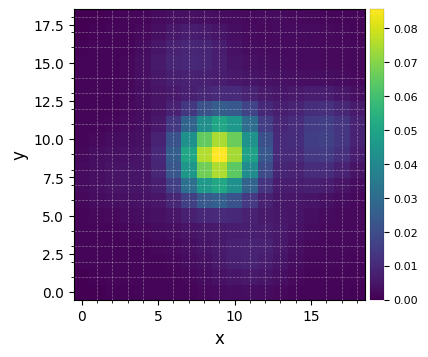

In [8]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `config` subpackage:

In [9]:
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


## 5.2. Generating and injecting synthetic planets

We first select an image library `imlib` for image operations (shifts, rotations) and associated `interpolation` order. 'vip-fft' is more accurate, but 'skimage' is faster, and 'opencv' even faster - see `Tutorial 7` for more details.

In [10]:
imlib_rot = 'opencv' #'skimage'
interpolation='lanczos4' #'biquintic'   

The `cube_inject_companions` function in the `fm` module (VIP versions >= 1.1.0) makes the injection of fake companions at arbitrary fluxes and locations very easy. The normalized non-coronagraphic PSF should be provided for the injection. If the user does not have access to an observed PSF, the `create_synth_psf` from the `var` module can be used to create synthetic ones (based on 2D Gaussian, Moffat or Airy models).

Some procedures, e.g. the negative fake companion technique and the contrast curve generation, heavily rely on the injection of fake companions. The coordinates for the injection should be provided in the **derotated** image, while the actual injection occurs in the images of the input cube, i.e. in the *rotated* field.

In [11]:
rad_fc = 30.5
theta_fc = 240
flux_fc = 400.

gt = [rad_fc, theta_fc, flux_fc]

In [12]:
cubefc = cube_inject_companions(cube, psf_template=psfn, angle_list=angs, flevel=flux_fc, plsc=pxscale_naco, 
                                rad_dists=[rad_fc], theta=theta_fc, n_branches=1, 
                                imlib=imlib_rot, interpolation=interpolation)


Let's set the corresponding cartesian coordinates:

In [13]:
cy, cx = frame_center(cube[0])
x_fc = cx + rad_fc*np.cos(np.deg2rad(theta_fc))
y_fc = cy + rad_fc*np.sin(np.deg2rad(theta_fc))

xy_test = (x_fc, y_fc)
print('({:.1f}, {:.1f})'.format(xy_test[0],xy_test[1]))

(34.7, 23.6)


Let's double-check the fake companion was injected at the right location, by post-processing the cube and checking the final image. Let's use PCA, and infer the optimal $n_{\rm pc}$ while we are at it - this will be useful for the next section.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-02-09 00:30:07
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.019434
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 41
Optimal number of PCs = 10, for S/N=13.415
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 34.7, 23.6
Flux in a centered 1xFWHM circular aperture = 104.785
Central pixel S/N = 18.264
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 13.415
Max S/N (shifting the aperture center) = 18.472
stddev S/N (shifting the aperture center) = 4.088



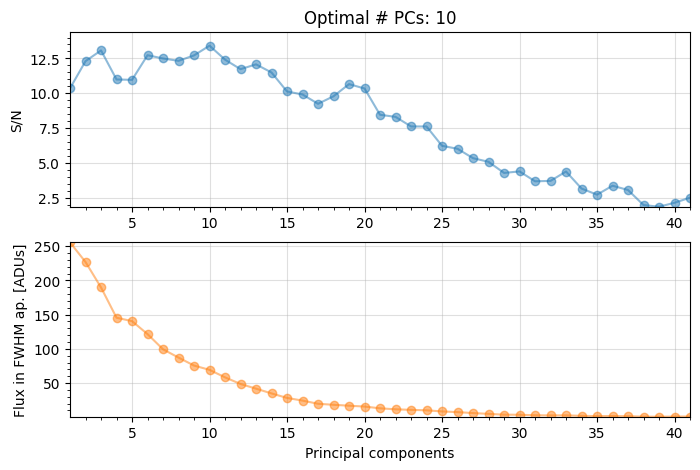

In [14]:
res_ann_opt = pca_grid(cubefc, angs, fwhm=fwhm_naco, range_pcs=(1,41,1), source_xy=xy_test, mode='annular',
                       annulus_width=4*fwhm_naco, imlib=imlib_rot, interpolation=interpolation, 
                       full_output=True, plot=True)

The grid search looking for the optimal number of principal components (npc) found that 10 principal components maximizes the S/N ratio of the injected fake companion. 

In [15]:
_, final_ann_opt, _, opt_npc_ann = res_ann_opt

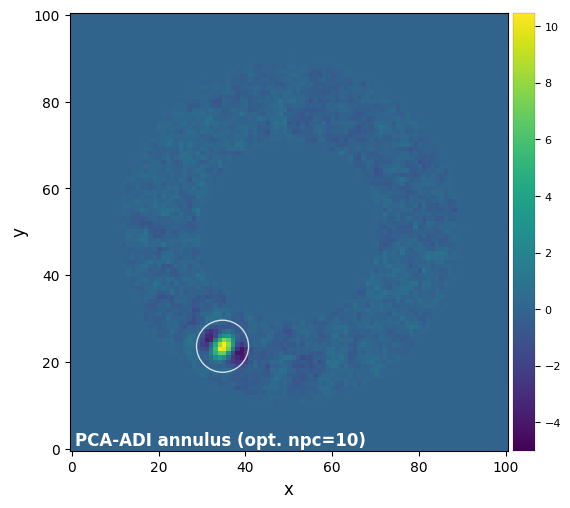

In [16]:
plot_frames(final_ann_opt, label='PCA-ADI annulus (opt. npc={:.0f})'.format(opt_npc_ann),
            dpi=100, vmin=-5, colorbar=True, circle=xy_test)

We can see that the fake companion was indeed injected at the requested location.

## 5.3. Flux and position estimation with NEGFC

When a companion candidate is detected, the next step is to characterize it, i.e. infer its exact position (astrometry) and flux (photometry). 

<font color=orange> **Question 5.1**: Why would a simple 2D Gaussian fit (as performed e.g. for the stellar PSF in Section 5.1) be inappropriate to extract the astrometry and photometry of a candidate companion? </font>

`VIP` implements the Negative fake companion (NEGFC) technique for robust extraction of the position and flux of detected point-like sources. The technique can be summarized as follow (see full description in [Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract)):

1) Estimate the position and flux of the planet, from either the visual inspection of reduced images or a previous estimator (see ABC below).

2) Scale (in flux) and shift the normalized off-axis PSF to remove the estimate from the input data cube.

3) Process the cube with PCA in a single annulus encompassing the point source.

4) Measure residuals in an aperture centered on the approximate location of the companion candidate.

5) Iterate on the position and flux of the injected negative PSF (steps 2-4), until the absolute residuals in the aperture are minimized (i.e. the injected negative companion flux and the position match exactly that of the true companion).

Iterations between steps 2-4 can be performed in one of 3 ways - sorted in increasing computation time and accuracy: 

A) a grid search on the flux only, provided a fixed estimate of the position (implemented in the `firstguess` function);

B) a Nelder-Mead simplex algorithm (`firstguess` function with the `simplex=True` option);

C) an MCMC sampler, which has the advantage to also yield uncertainties on each of the parameters of the point source (`mcmc_negfc_sampling` function).

Different figures of merit can be used for minimization of the residuals ([Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract); [Christiaens et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.6117C/abstract)):
$$\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}~~({\rm default}), ~~~~~~~~\chi^2 = \sum_j^N |I_j|, ~~~~~~~~\chi^2 = N {\rm std}(I_j).$$

where $j \in {1,...,N}$, $N$ is the total number of pixels contained in the circular aperture around the companion candidate, $\mu$ and $\sigma$ are the mean and standard deviation ($N_{\rm resel}$ degrees of freedom) of pixel intensities in a truncated annulus at the radius of the companion candidate, but avoiding the azimuthal region encompassing the negative side lobes.

### 5.3.1. Nelder-Mead based optimization

With the function `firstguess`, we can obtain a first estimation of the flux and position by running A) a naive grid minimization (grid of values for the flux through parameter `f_range`), and B) a Nelder-mead based minimization (if the parameter `simplex` is set to *True*). The latter is done based on the preliminary guess of the grid minimization. The maximum number of iterations and error can be set with the parameter `simplex_options` as a dicitionary (see `scipy.minimize` function for the Nelder-Mead options).

Fisrt we define the position of the sources by examining a flux frame or S/N map. `planets_xy_coord` takes a list or array of X,Y pairs like ((x1,y1),(x2,y2)...(x_n,y_n)). Let's take the coordinates of the previously injected companion.

Let's test the algorithm with different values for the # of PCs: 5 and 25.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-02-09 00:30:13
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   1.933
2/30   0.149   1.933
3/30   0.221   1.932
4/30   0.329   1.931
5/30   0.489   1.930
6/30   0.728   1.927
7/30   1.083   1.924
8/30   1.610   1.919
9/30   2.395   1.912
10/30   3.562   1.901
11/30   5.298   1.886
12/30   7.880   1.862
13/30   11.721   1.827
14/30   17.433   1.776
15/30   25.929   1.698
16/30   38.566   1.581
17/30   57.362   1.416
18/30   85.317   1.191
19/30   126.896   0.907
20/30   188.739   0.543
21/30   280.722   0.175
22/30   417.532   0.043


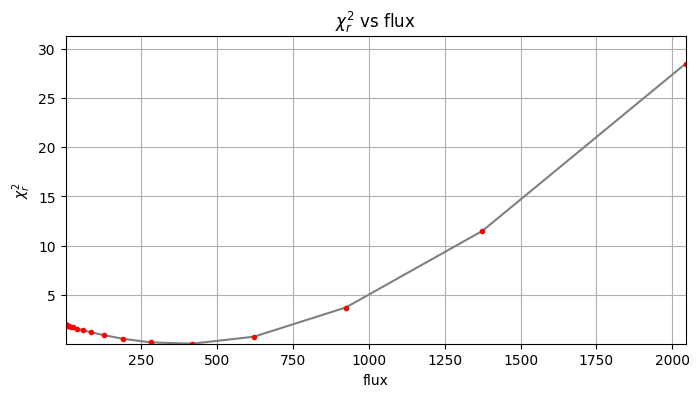

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.5
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 83, nfev: 189, chi2r: 0.027624985643925556
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.547, 239.971, 384.908) at 
          (X,Y)=(34.71, 23.55)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:30.170114
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [17]:
r_lo, theta_lo, f_lo = firstguess(cubefc, angs, psfn, ncomp=5, planets_xy_coord=[xy_test], 
                                  fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                  aperture_radius=2, simplex=True, imlib=imlib_rot, 
                                  interpolation=interpolation, plot=True, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-02-09 00:30:44
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   0.322
2/30   0.149   0.322
3/30   0.221   0.322
4/30   0.329   0.322
5/30   0.489   0.322
6/30   0.728   0.322
7/30   1.083   0.322
8/30   1.610   0.322
9/30   2.395   0.322
10/30   3.562   0.322
11/30   5.298   0.321
12/30   7.880   0.320
13/30   11.721   0.319
14/30   17.433   0.317
15/30   25.929   0.313
16/30   38.566   0.310
17/30   57.362   0.301
18/30   85.317   0.272
19/30   126.896   0.244
20/30   188.739   0.197
21/30   280.722   0.117
22/30   417.532   0.064


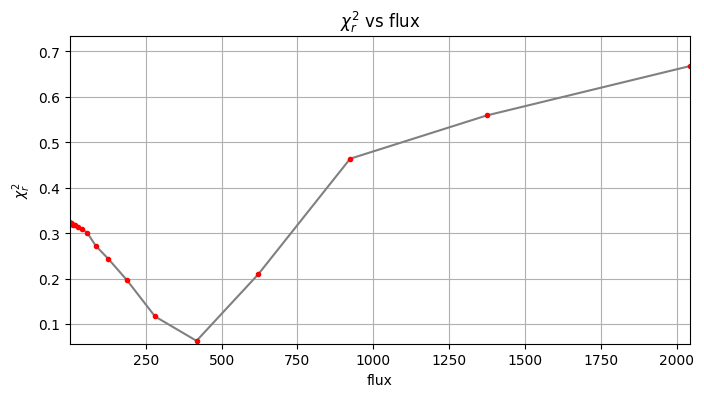

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.5
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 65, nfev: 172, chi2r: 0.05751325883938156
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.186, 239.897, 424.183) at 
          (X,Y)=(34.86, 23.89)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:25.975863
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [18]:
r_hi, theta_hi, f_hi = firstguess(cubefc, angs, psfn, ncomp=25, planets_xy_coord=[xy_test], 
                                  fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                  aperture_radius=2, imlib=imlib_rot, interpolation=interpolation, 
                                  simplex=True, plot=True, verbose=True)

For both the $n_{\rm pc} = 5$ and $n_{\rm pc} = 25$ cases, the parameters estimated by the Nelder-Mead optimization are not exactly equal to the original values (radius=30.5, theta=240, flux=400), which reflects:

- the limitations of this heuristic minization procedure (depending on the initial guess the minimization may get trapped in a different local minimum);
- the higher residual speckle noise level in images obtained with low $n_{\rm pc}$ values; 
- the higher self-subtraction for high $n_{\rm pc}$ values.

These estimates are provided without uncertainties (error bars). We will come back to this question later on. 

For comparison, let's use the optimal $n_{\rm pc} = 10$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets):

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-02-09 00:31:10
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   1.951
2/30   0.149   1.951
3/30   0.221   1.950
4/30   0.329   1.950
5/30   0.489   1.948
6/30   0.728   1.946
7/30   1.083   1.944
8/30   1.610   1.939
9/30   2.395   1.933
10/30   3.562   1.924
11/30   5.298   1.911
12/30   7.880   1.891
13/30   11.721   1.861
14/30   17.433   1.818
15/30   25.929   1.749
16/30   38.566   1.661
17/30   57.362   1.523
18/30   85.317   1.288
19/30   126.896   1.010
20/30   188.739   0.637
21/30   280.722   0.218
22/30   417.532   0.052


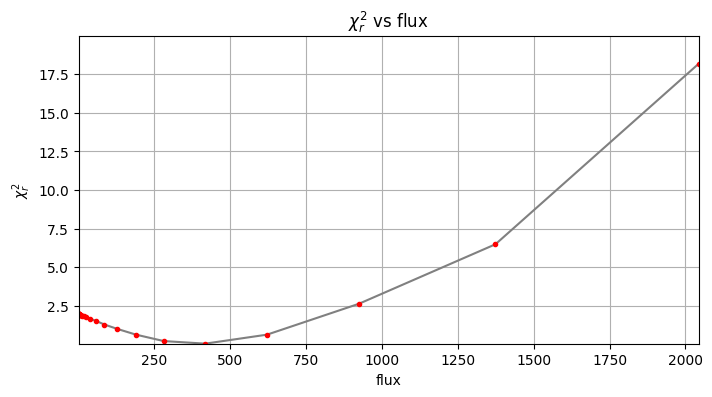

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.5
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 78, nfev: 194, chi2r: 0.04394242599720263
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.534, 239.932, 391.000) at 
          (X,Y)=(34.70, 23.57)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:29.126147
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [19]:
r_0, theta_0, f_0 = firstguess(cubefc, angs, psfn, ncomp=opt_npc_ann, planets_xy_coord=[xy_test], 
                               fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                               aperture_radius=2, imlib=imlib_rot, interpolation=interpolation, 
                               simplex=True, plot=True, verbose=True)

We see that using the optimal $n_{\rm pc}$ leads to a closer parameter estimates to the ground truth.

<font color=green> **Answer 5.1**: If relying on a 2D Gaussian fit, both the photometry and astrometry would be biased by self-subtraction and the negative side lobes. </font>

### 5.3.2. Planet subtraction

Let's use the values obtained with the simplex optimization to subtract the planet with the function `cube_planet_free`.

First we define a list with the parameters (r, theta, flux) is each companion that we obtained via the NegFC, in this case one:

In [20]:
plpar_fc = [(r_0[0], theta_0[0], f_0[0])]

Note: r_0, theta_0 and f_0 have the same length as the number of planet coordinates `planets_xy_coord` provided to `firstguess`. Here there is only one planet, so we take the zeroth index. The number of tuples in (i.e the length of) `plpar_fc` should match the number of planets.

In [21]:
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)

Let's double-check the fake companion was well removed by computing a PCA post-processed image:

In [22]:
from vip_hci.preproc import cube_derotate
from vip_hci.config import time_ini, timing
t0 = time_ini()
for i in range(100):
    fr_pca_emp = pca_annulus(cube_emp, angs, ncomp=opt_npc_ann, annulus_width=4*fwhm_naco, 
                             r_guess=rad_fc, imlib=imlib_rot, interpolation=interpolation)
    #cube_tmp = cube_derotate(cube_emp, angs, imlib=imlib_rot, interpolation=interpolation, edge_blend='')
timing(t0)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-02-09 00:31:39
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:10.708469
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's take a look at the PSF of the planet in the full-frame PCA final image and the same PSF in the frame resulting of processing the planet-subtracted cube:

In [23]:
cropped_frame1 = frame_crop(final_ann_opt, cenxy=xy_test, size=15)

New shape: (15, 15)


In [24]:
cropped_frame2 = frame_crop(fr_pca_emp, cenxy=xy_test, size=15)

New shape: (15, 15)


Let's use both `'mode=surface'` and the default image mode of `plot_frames` to show the residuals in the vicinity of the companion:

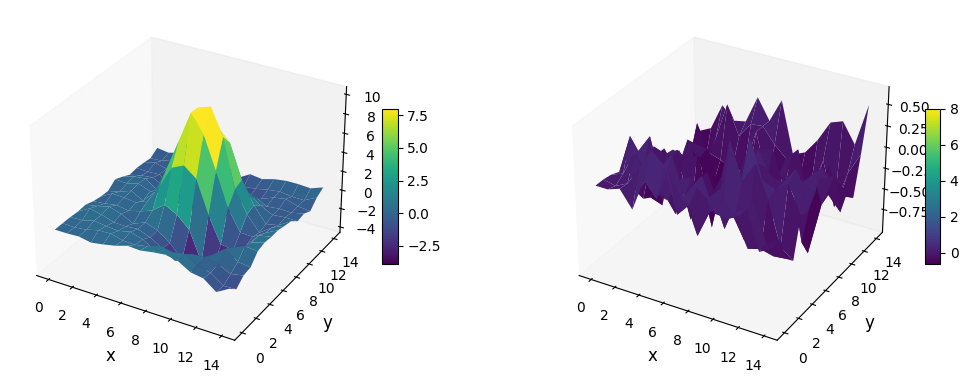

In [25]:
plot_frames((cropped_frame1, cropped_frame2), mode='surface', vmax=8)

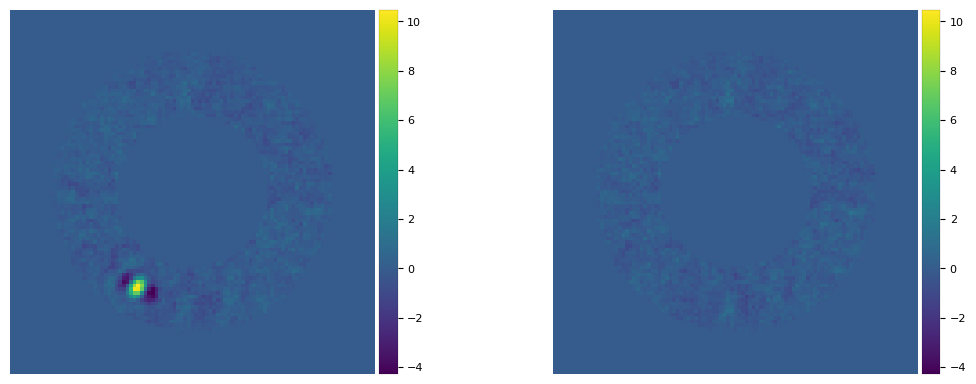

In [26]:
plot_frames((final_ann_opt, fr_pca_emp), vmin = float(np.amin(final_ann_opt)), 
            vmax= float(np.amax(final_ann_opt)), axis=False)

Not only the bright point-like signal is subtracted, but so are the negative side lobes. A subtraction not leaving any significant artifact/defect is a good sign that the inferred parameters are correct. However, keep in mind that even for slightly inaccurate parameters, the final image can still look relatively clean. Let's take for example the parameters inferred with non-optimal $n_{\rm pc}$: 

[(30.546939377902838, 239.97143072926895, 384.907744766204)]


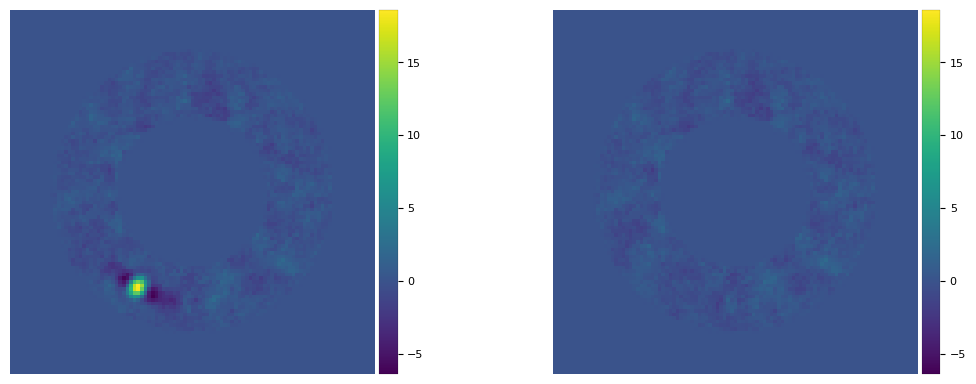

In [27]:
# planet parameters inferred from npc=5 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_lo[0], theta_lo[0], f_lo[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)
final_ann_5 = pca_annulus(cubefc, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp5 = pca_annulus(cube_emp, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_5, fr_pca_emp5), vmin = float(np.amin(final_ann_5)), 
            vmax= float(np.amax(final_ann_5)), axis=False)

[(30.185654422615254, 239.89730553041744, 424.1830127798898)]


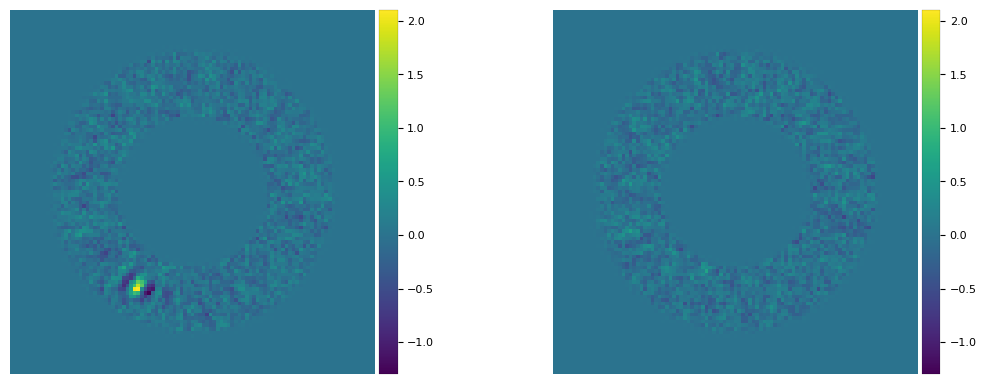

In [28]:
# parameters inferred from npc=25 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_hi[0], theta_hi[0], f_hi[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)
final_ann_25 = pca_annulus(cubefc, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp25 = pca_annulus(cube_emp, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_25, fr_pca_emp25), vmin = float(np.amin(final_ann_25)), 
            vmax= float(np.amax(final_ann_25)), axis=False)

Inaccurate parameters still leading to an apparently good removal of the companion brings the question of the uncertainties on each of the three parameters characterizing the companion. The next sections are dedicated to this question. 

### 5.3.3. NEGFC technique coupled with MCMC

#### 5.3.3.1. Running the MCMC sampler

MCMC is a more robust way of obtaining the flux and position. It samples the posterior distributions of the parameters and from them we can infer both the most likely parameter values and uncertainties on each parameter. The relevant function is `mcmc_negfc_sampling`, which can accept a number of parameters. Let's define them in the next few boxes:

Let's first define observation-related parameters, such as the non-coronagraphic psf, its FWHM and the pixel scale od the detector: 

In [29]:
obs_params = {'psfn': psfn,
              'fwhm': fwhm_naco}

In NEGFC, PCA in a single annulus is used by default to speed up the algorithm - although other algorithms can be used through the `algo` parameter. Let's set the $n_{\rm pc}$ to the optimal $n_{\rm pc}$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets). We set the width of the annulus on which PCA is performed (in pixels) with the `annulus_width` parameter. We also set a few other algorithm-related parameters in the following box:

In [30]:
annulus_width = 4*fwhm_naco

algo_params = {'algo': pca_annulus,
               'ncomp': opt_npc_ann,
               'annulus_width': annulus_width,
               'svd_mode': 'lapack',
               'imlib': imlib_rot, 
               'interpolation': interpolation}

The choice of log-likelihood expression to be used is determined by `mu_sigma` and `fm`. If the former is True (default; mu and sigma calculated automatically) or a tuple of 2 values, the following figure of merit will be used: $\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}$. Otherwise, the choice will be determined by `fm`: 'sum' for the sum of absolute residuals, or 'stddev' for the standard deviation of residuals (which can be useful if the point source is contained within a more extended signal).
`aperture_radius` is the radius of the aperture  (in `fwhm` units) in which the residual intensities $I_j$ are considered.

In [31]:
mu_sigma=True
aperture_radius=2

negfc_params = {'mu_sigma': mu_sigma,
                'aperture_radius': aperture_radius}

Parameter ``initial_state`` corresponds to the initial first estimation of the planets parameters (r, theta, flux). We set it to the result of the simplex optimization, obtained with optimal $n_{\rm pc}$. Note that the MCMC minimization can only run for one companion candidate at a time, hence the first dimension of init should always be 3 (not the number of planets, as opposed to `planets_xy_coord` in `firstguess`).

In [32]:
initial_state = np.array([r_0[0], theta_0[0], f_0[0]])

Beware that the MCMC procedure is a CPU intensive procedure and can take several hours when run properly on a standard laptop. We use the affine invariant sampler from `emcee` which can be run in parallel (`nproc` sets the number of CPUs to be used). At least 100 walkers are recommended for our MCMC chain, although both the number of walkers and iterations will depend on your dataset. 
For the sake of preventing this tutorial to take too long to run, we set the maximum number of iterations to 500, although feel free to significantly increase it in case of non-convergence.

In [33]:
from multiprocessing import cpu_count

nwalkers, itermin, itermax = (100, 200, 500)

mcmc_params = {'nwalkers': nwalkers,
               'niteration_min': itermin,
               'niteration_limit': itermax,
               'bounds': None,
               'nproc': cpu_count()//2}


Another update from Christiaens et al. (2021) is that the convergence can now be evaluated based on the auto-correlation time (see more details in the [documentation of `emcee`](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/)), instead of the Gelman-Rubin test, which is inappropriate for non-independent samples (such as an MCMC chain).
We set the convergence test to the autocorrelation time based criterion using `conv_test='ac'` (instead of Gelman-Rubin 'gb'). We also set the autocorrelation criterion $N/\tau >= a_c$, where $N$ is the number of samples and $\tau$ the autocorrelation time, to `ac_c=50` (the value recommended in the `emcee` documentation). Finally, we set the number of consecutive times the criterion must be met to: `ac_count_thr=1`, and the maximum gap in number of steps between 2 checks of the convergence criterion to: `check_maxgap=50`. If the maximum number of iterations `niteration_limit` is large enough, the chain will stop upon meeting the convergence criterion (spoiler: it won't be the case here since we chose a small value for `niteration_limit`).

In [34]:
conv_test, ac_c, ac_count_thr, check_maxgap = ('ac', 50, 1, 50)

conv_params = {'conv_test': conv_test,
               'ac_c': ac_c,
               'ac_count_thr': ac_count_thr,
               'check_maxgap': check_maxgap}

Setting `bounds=None` does *not* mean no bounds are used for parameter exploration, but rather that they are set automatically to:

- $r \in [r_0-w_{ann}/2, r_0+w_{ann}/2]$, where $w_{ann}$ is the `annulus_width`,
- $\theta \in [\theta_0-\Delta {\rm rot}, \theta_0+\Delta {\rm rot}]$, where $\Delta {\rm rot}$ is the angle subtended by min(`aperture_radius`/2,`fwhm`) at $r_0$,
- $f \in [0.1*f_0, 2*f_0]$,

where ($r_0, \theta_0, f_0$) = `initial_state`.
If the `bounds` are provided manually (as a tuple of tuples), they will supersede the automatic setting above.

Now let's start the sampler. Note that this step is computer intensive and may take a long time to run depending on your machine. Feel free to skip the next box if you do not wish to run the MCMC or can't run it in a reasonable time. The results are already saved as 'MCMC_results' in the 'datasets' folder and will be loaded in the subsequent boxes.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-02-09 00:31:51
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
        MCMC sampler for the NEGFC technique       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
The mean and stddev in the annulus at the radius of the companion (excluding the PA area directly adjacent to it) are -0.05 and 1.50 respectively.
Beginning emcee Ensemble sampler...
emcee Ensemble sampler successful

Start of the MCMC run ...
Step  |  Duration/step (sec)  |  Remaining Estimated Time (sec)
0		7.13213			3558.93262
1		3.61667			1801.09967
2		3.70482			1841.29355
3		3.64208			1806.47069
4		3.87700			1919.11401
5		4.62709			2285.78394
6		3.49562			1723.34263
7		3.44389			1694.39536
8		3.10109			1522.63323
9		3.47290			1701.72345
10		3.50236			1712.65551
11		3.50096			1708.47092
12		3.70828			1805.93285
13		3.39370			1649.33917
14		2.97538			1443.058

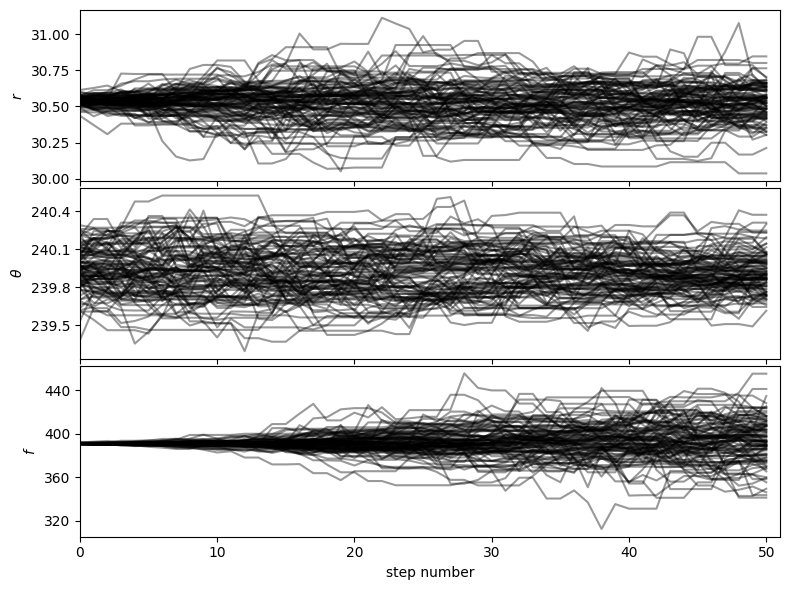

51		3.45667			1548.58906
52		2.87915			1286.98005
53		2.86919			1279.65785
54		2.86559			1275.18933
55		2.92598			1299.13690
56		3.09593			1371.49655
57		2.88468			1275.02989
58		2.87401			1267.43797
59		2.90538			1278.36808
60		2.88652			1267.18272
61		3.30384			1447.08061
62		3.58913			1568.44937
63		2.99779			1307.03688
64		2.91834			1269.47703
65		2.94874			1279.75359
66		2.97274			1287.19772
67		2.85810			1234.70050
68		2.87300			1238.26386
69		2.84728			1224.32911
70		2.83904			1217.94816
71		2.83286			1212.46494
72		2.89113			1234.51251
73		2.84431			1211.67521
74		2.83840			1206.32212
75		2.82446			1197.57104
76		2.83292			1198.32389
77		2.82845			1193.60801
78		2.83130			1191.97814
79		2.90486			1220.03952
80		3.13364			1312.99516
81		3.05744			1278.01034
82		3.36742			1404.21497
83		3.46365			1440.87923
84		3.15903			1310.99662
85		2.86348			1185.48072
86		3.04708			1258.44569
87		3.06656			1263.42148
88		2.96695			1219.41809
89		2.89121			1185.39610
90		2.85310			1166.91708


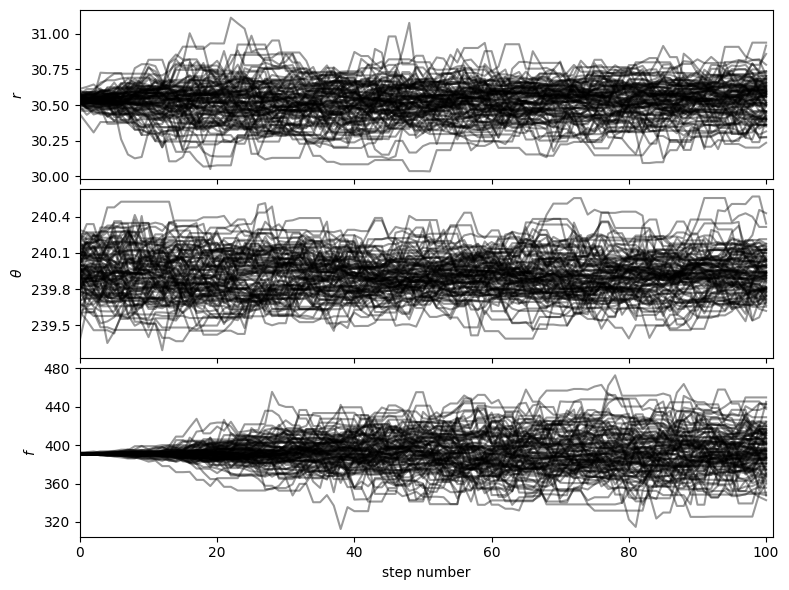

101		3.56390			1418.43140
102		3.03378			1204.40907
103		2.98589			1182.41323
104		2.91651			1152.01987
105		2.83992			1118.92730
106		2.83424			1113.85593
107		2.83961			1113.12908
108		2.83898			1110.04196
109		2.86051			1115.60046
110		2.92244			1136.82955
111		2.88897			1120.91997
112		2.89902			1121.92268
113		2.87165			1108.45690
114		2.93836			1131.26860
115		2.93455			1126.86605
116		2.89740			1109.70535
117		2.93155			1119.85057
118		3.18682			1214.17690
119		2.98511			1134.34332
120		3.20946			1216.38534
121		3.39752			1284.26218
122		3.62876			1368.04101
123		3.09671			1164.36334
124		2.90877			1090.79062
125		3.24938			1215.26812
126		2.96282			1105.13335
127		3.04409			1132.40297
128		2.97681			1104.39540
129		3.06871			1135.42307
130		3.29705			1216.61219
131		2.99975			1103.90726
132		2.90742			1067.02461
133		3.04345			1113.90087
134		3.10549			1133.50348
135		3.17026			1153.97318
136		3.08089			1118.36343
137		2.96913			1074.82506
138		2.99595			1081.53723
139		3.07808

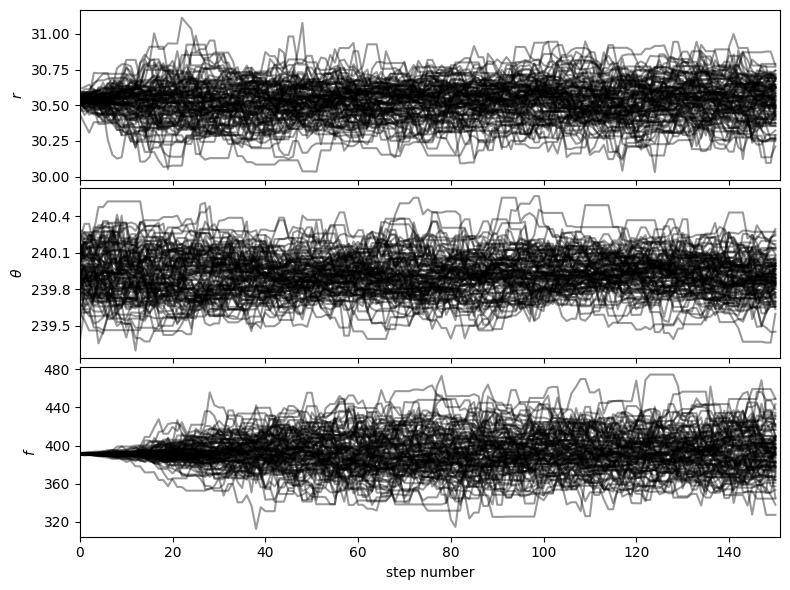

151		3.40695			1185.61964
152		2.90158			1006.84861
153		2.83831			982.05595
154		2.83793			979.08757
155		2.85073			980.64940
156		3.17041			1087.44891
157		2.93393			1003.40269
158		2.89393			986.83047
159		2.83944			965.40858
160		2.86242			970.36106
161		3.14914			1064.41000
162		3.57811			1205.82374
163		3.24533			1090.43222
164		2.95293			989.23189
165		2.85631			954.00787
166		2.83024			942.47092
167		3.06218			1016.64509
168		3.16876			1048.85956
169		3.20437			1057.44309
170		3.03823			999.57866
171		3.12734			1025.76818
172		3.33682			1091.14112
173		3.10358			1011.76708
174		3.18954			1036.59920
175		3.00691			974.23949
176		2.94042			949.75469
177		2.94042			946.81427
178		2.86714			920.35034
179		2.89539			926.52544
180		3.07692			981.53716
181		3.54745			1128.08942
182		3.00233			951.73798
183		2.91683			921.71765
184		2.95652			931.30506
185		2.94284			924.05019
186		3.22183			1008.43216
187		3.04915			951.33418
188		3.03979			945.37624
189		3.08693			956.94923
190		2.95

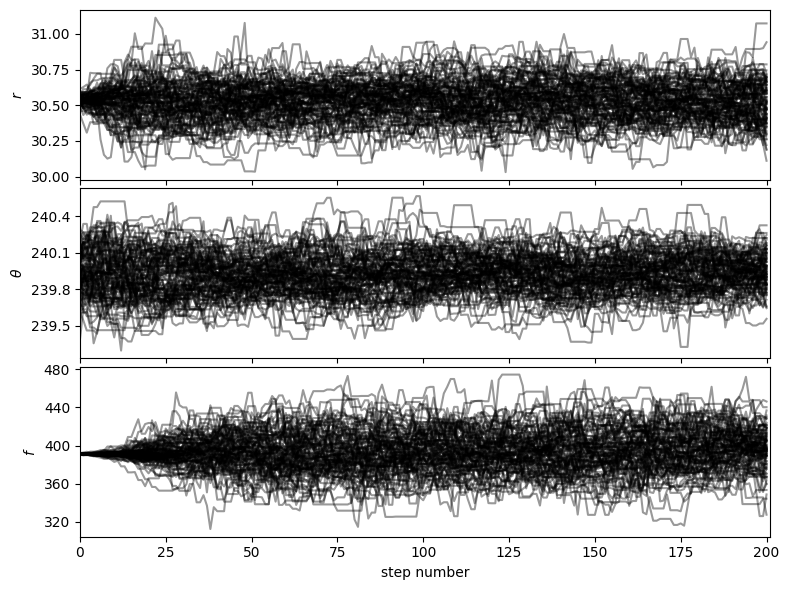

Auto-corr tau/N = [0.07095674 0.07094065 0.06465227]
tau/N <= 0.02 = [False False False] 

201		3.68647			1098.56657
202		2.87609			854.19754
203		2.86975			849.44600
204		3.09459			912.90434
205		3.05472			898.08856
206		2.95464			865.70923
207		2.86362			836.17792
208		3.04103			884.94060
209		3.31540			961.46513
210		3.32127			959.84674
211		3.02942			872.47411
212		3.04211			873.08586
213		3.05404			873.45458
214		2.91052			829.49706
215		2.84714			808.58719
216		2.90828			823.04381
217		2.96809			837.00251
218		3.00457			844.28361
219		2.95907			828.53960
220		3.09547			863.63613
221		3.21926			894.95372
222		2.95727			819.16490
223		2.91807			805.38760
224		2.91379			801.29308
225		2.94934			808.11779
226		3.16563			864.21699
227		2.96380			806.15469
228		2.92977			793.96632
229		2.93079			791.31411
230		2.87159			772.45771
231		2.88208			772.39851
232		2.85168			761.39883
233		2.87572			764.94046
234		2.94423			780.22121
235		2.87284			758.43002
236		2.84403			747.98068
237		2.8

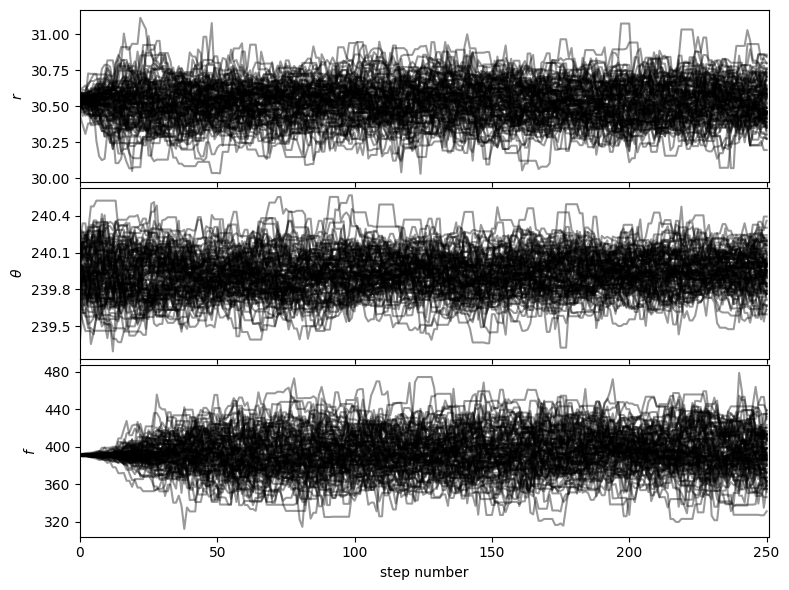

Auto-corr tau/N = [0.06292658 0.06170675 0.06216875]
tau/N <= 0.02 = [False False False] 

251		3.48417			864.07490
252		3.11456			769.29731
253		3.09050			760.26251
254		3.07221			752.69120
255		3.26513			796.69221
256		3.10956			755.62259
257		2.89068			699.54456
258		2.85150			687.21150
259		2.90899			698.15736
260		3.44380			823.06796
261		3.15258			750.31428
262		3.02845			717.74265
263		3.06368			723.02966
264		2.95856			695.26254
265		2.88525			675.14756
266		2.92218			680.86864
267		2.93242			680.32121
268		2.87580			664.30911
269		3.14708			723.82863
270		3.00225			687.51548
271		2.88905			658.70431
272		2.89366			656.86127
273		2.93273			662.79698
274		2.93086			659.44350
275		2.90250			650.16022
276		2.85422			636.49173
277		2.86190			635.34158
278		2.95948			654.04442
279		2.87584			632.68524
280		2.97128			650.70966
281		3.33502			727.03480
282		3.04260			660.24333
283		2.98999			645.83827
284		3.10137			666.79412
285		3.06738			656.41868
286		3.12120			664.81539
287		3.30

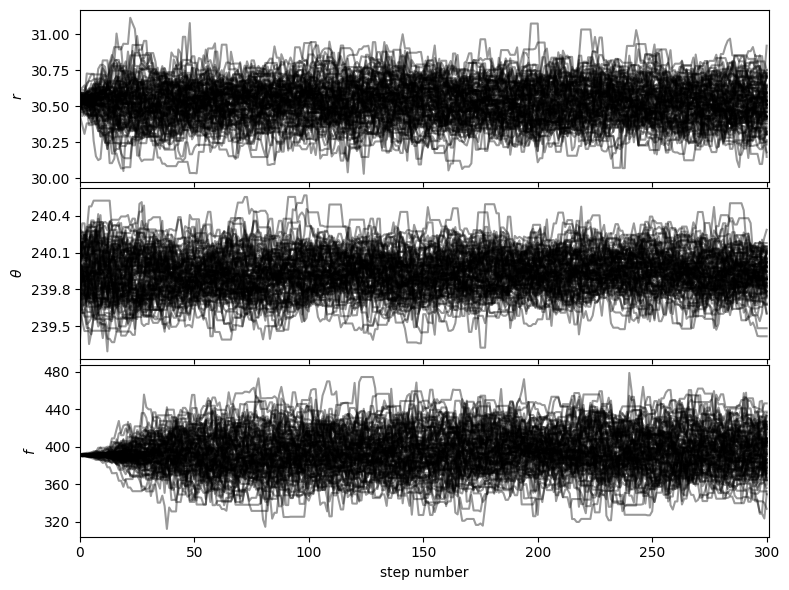

Auto-corr tau/N = [0.05818551 0.05553562 0.05801175]
tau/N <= 0.02 = [False False False] 

301		3.64570			721.84781
302		2.91112			573.49084
303		2.94085			576.40621
304		3.00697			586.35993
305		2.98398			578.89115
306		2.92559			564.63926
307		2.85602			548.35622
308		2.93674			560.91810
309		2.90747			552.41835
310		2.86775			542.00532
311		2.84892			535.59771
312		2.84920			532.80133
313		2.86231			532.39022
314		2.84846			526.96473
315		2.86975			528.03363
316		2.93589			537.26878
317		2.98862			543.92866
318		2.95565			534.97175
319		2.99944			539.89866
320		3.01379			539.46859
321		3.28976			585.57781
322		2.96882			525.48132
323		3.02348			532.13283
324		2.93052			512.84170
325		3.08962			537.59388
326		2.94666			509.77253
327		2.87762			494.94978
328		2.89918			495.75927
329		2.98007			506.61224
330		3.24989			549.23192
331		3.25576			546.96785
332		3.00641			502.07064
333		3.00982			499.62929
334		2.92267			482.24121
335		2.86428			469.74159
336		3.07366			501.00625
337		2.91

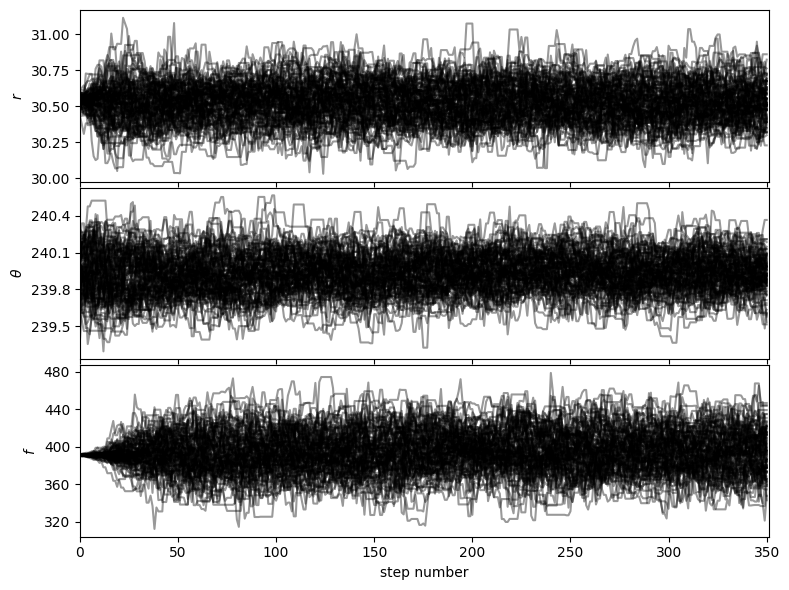

Auto-corr tau/N = [0.05283253 0.05348335 0.05418299]
tau/N <= 0.02 = [False False False] 

351		3.40483			503.91543
352		2.94996			433.64427
353		3.09218			451.45770
354		3.12517			453.14979
355		2.94310			423.80640
356		2.95830			423.03661
357		3.02824			430.00980
358		2.92309			412.15597
359		2.94784			412.69704
360		3.39586			472.02454
361		2.99180			412.86840
362		2.94130			402.95851
363		2.94622			400.68619
364		2.92002			394.20229
365		2.90891			389.79434
366		2.92838			389.47467
367		2.93373			387.25262
368		2.90981			381.18485
369		2.96031			384.84043
370		2.92102			376.81132
371		2.98143			381.62240
372		3.23266			410.54795
373		3.01426			379.79739
374		2.94095			367.61912
375		3.11868			386.71657
376		3.57227			439.38872
377		3.70037			451.44563
378		3.40558			412.07542
379		4.30228			516.27324
380		3.81015			453.40761
381		2.98753			352.52795
382		2.87914			336.85903
383		2.86167			331.95418
384		2.86169			329.09435
385		2.86788			326.93786
386		2.88105			325.55888
387		3.08

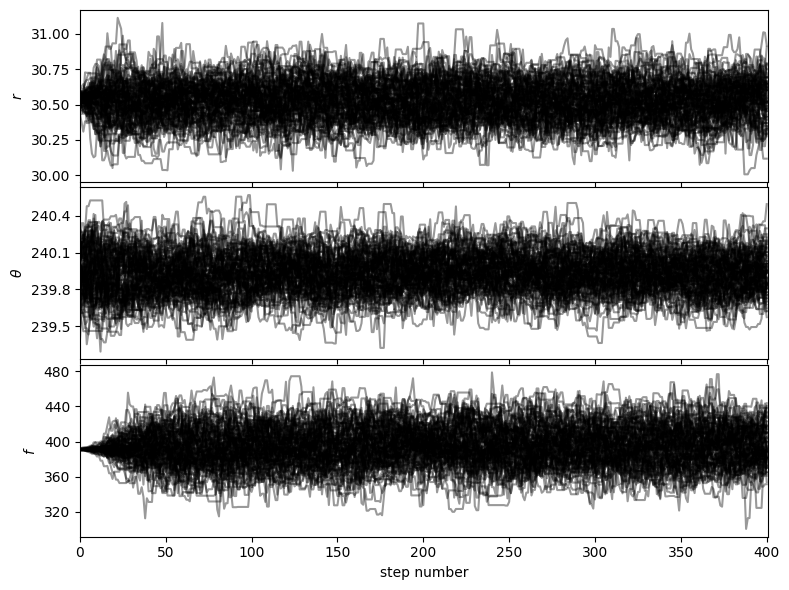

Auto-corr tau/N = [0.04786285 0.0491615  0.04972032]
tau/N <= 0.02 = [False False False] 

401		3.46231			339.30589
402		2.98726			289.76441
403		2.90570			278.94691
404		2.92778			278.13862
405		3.04121			285.87327
406		3.22554			299.97513
407		3.14143			289.01156
408		3.69533			336.27521
409		3.39257			305.33121
410		3.34785			297.95892
411		2.97537			261.83282
412		2.89877			252.19255
413		2.89737			249.17348
414		3.09092			262.72828
415		2.91639			244.97659
416		2.92387			242.68088
417		3.11274			255.24460
418		3.08596			249.96260
419		2.86848			229.47832
420		2.88891			228.22413
421		2.87960			224.60880
422		2.85228			219.62548
423		2.85882			217.27070
424		2.86385			214.78852
425		2.84689			210.67008
426		2.84562			207.73004
427		2.85453			205.52587
428		2.85555			202.74398
429		2.88473			201.93103
430		2.89416			199.69725
431		2.85913			194.42064
432		2.85099			191.01620
433		2.85327			188.31582
434		2.86206			186.03370
435		2.91247			186.39789
436		2.84587			179.28981
437		2.85

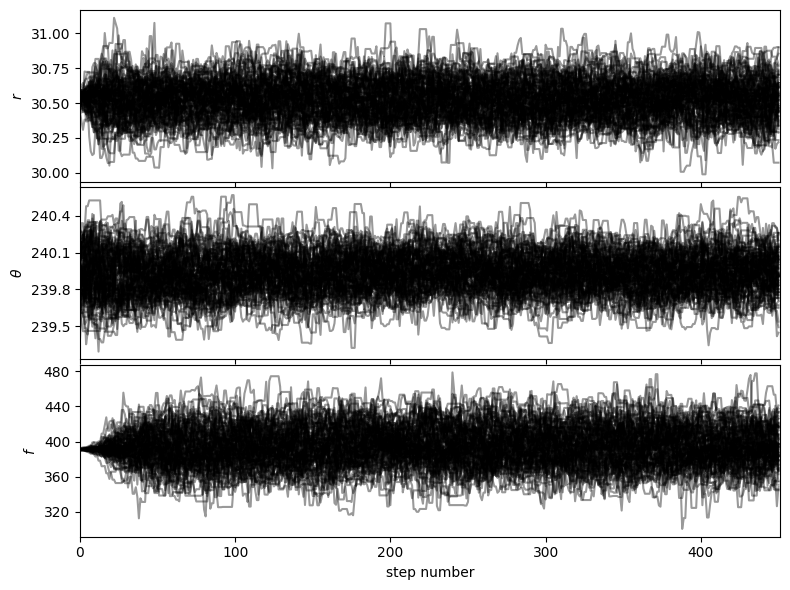

Auto-corr tau/N = [0.0445525  0.04465253 0.04605865]
tau/N <= 0.02 = [False False False] 

451		3.44063			165.15005
452		2.85631			134.24676
453		3.09404			142.32575
454		2.88659			129.89646
455		2.86710			126.15249
456		2.85833			122.90815
457		2.86230			120.21639
458		2.95646			121.21478
459		3.16727			126.69096
460		2.88180			112.39008
461		2.85010			108.30380
462		2.84148			105.13483
463		2.84253			102.33126
464		2.85000			99.75003
465		2.85702			97.13868
466		2.84858			94.00307
467		2.84719			91.10995
468		2.85911			88.63250
469		2.84694			85.40805
470		2.84338			82.45796
471		2.84572			79.68022
472		2.86358			77.31674
473		2.84678			74.01623
474		2.85776			71.44395
475		2.85296			68.47111
476		2.84444			65.42203
477		2.89367			63.66083
478		2.84860			59.82066
479		2.95802			59.16036
480		3.16991			60.22827
481		2.89189			52.05409
482		2.85587			48.54979
483		2.84266			45.48262
484		2.84610			42.69145
485		2.84342			39.80789
486		2.85201			37.07614
487		2.84078			34.08942
488		2.8

In [35]:
chain = mcmc_negfc_sampling(cubefc, angs, **obs_params, **algo_params, **negfc_params, 
                            initial_state=initial_state, **mcmc_params, **conv_params,
                            display=True, verbosity=2, save=False, output_dir='./')

If you ran the previous box and wish to write your results, set `write=True` in the next box. This will pickle the MCMC chain.

In [36]:
write=False

if write:
    import pickle
    output = {'chain':chain}
    with open('../datasets/my_MCMC_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

Note that an alternative to the box above, is to provide `output_dir` in the call to `mcmc_negfc_sampling` and set `save` to True. This will save the results as a pickle including additional keys: apart from 'chain', it will also save 'input_parameters', 'AR' (acceptance ratio), and 'lnprobability'.

Pickled results can be loaded from disk like this:

In [37]:
import pickle
with open('../datasets/MCMC_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    mcmc_result = myPickler.load()

print(mcmc_result.keys())
chain = mcmc_result['chain']

dict_keys(['chain', 'input_parameters', 'AR', 'lnprobability'])


The most accurate approach would involve setting a large enough maximum number of iterations and using FFT-based rotation for PCA. The latter in particular, may change a bit the most likely parameter values given the better flux conservation. However, these changes would involve over ~3 orders of magnitude longer calculation time. It is therefore intractable for a personal laptop and not shown in this notebook. If you have access to a supercomputer feel free to adopt these changes though. The results after 500 iterations are nonetheless good enough for illustrative purpose:

#### 5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots 

Let's first check that the walk plots look ok:

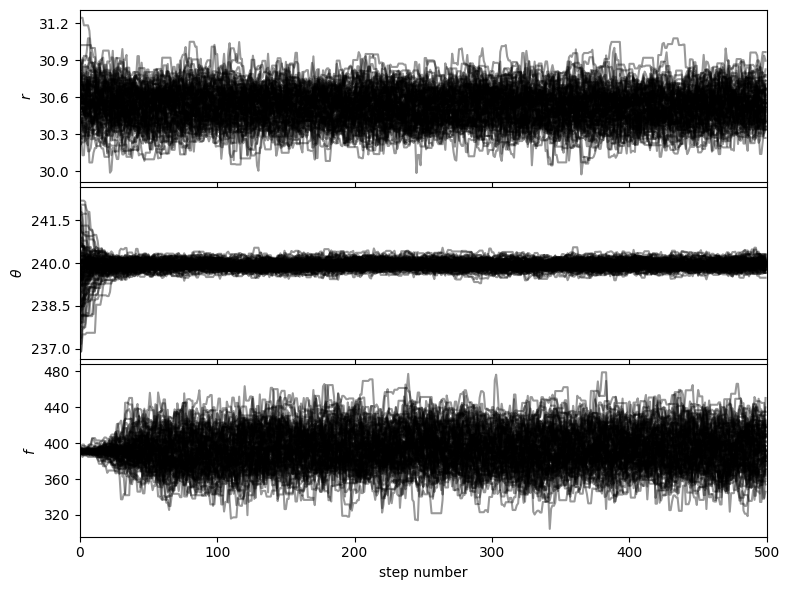

In [38]:
show_walk_plot(chain)

Then based on the walk plot, let's burn-in the first 30% of the chain, to calculate the corner plots:

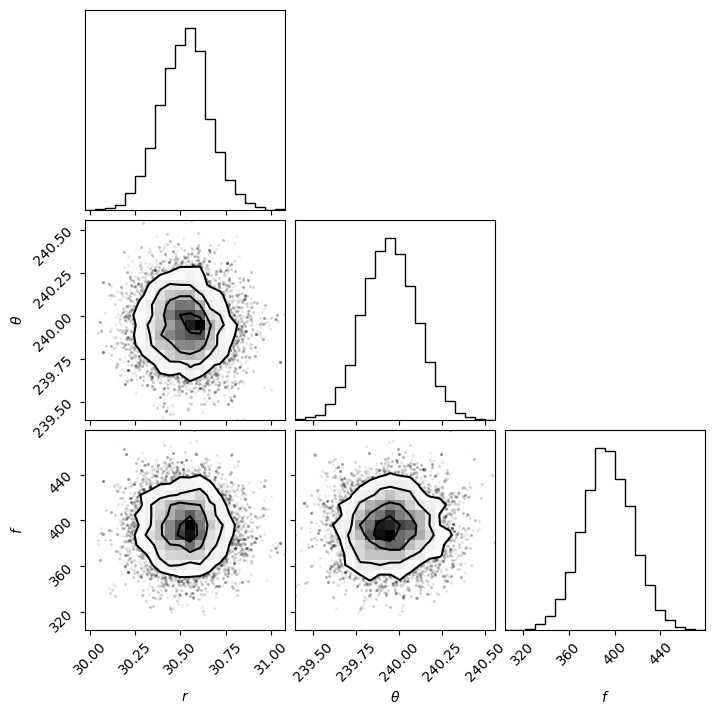

In [39]:
burnin = 0.3
burned_chain = chain[:, int(chain.shape[1]//(1/burnin)):, :]
show_corner_plot(burned_chain)

For the purpose of this tutorial and to limit computation time we set the maximum number of iterations to 500 for 100 walkers. The look of the corner plots may improve with more samples (i.e. higher number of iterations, for a given burn-in ratio). This can be tested by setting the max. number of iterations arbitrarily high for the autocorrelation-time convergence criterion to be met.

#### 5.3.3.3. Highly probable values and confidence intervals 

Now let's determine the most highly probable value for each model parameter, as well as the 1-sigma confidence interval. For this, let's first flatten the chains:

In [40]:
isamples_flat = chain[:, int(chain.shape[1]//(1/burnin)):, :].reshape((-1,3))

Then use the `confidence` function:

percentage for r: 69.79202279202278%
percentage for theta: 69.02279202279202%
percentage for f: 68.94017094017094%


Confidence intervals:
r: 30.57489764243517 [-0.20421878422770945,0.08279139901123145]
theta: 239.91771004343246 [-0.14527599962792692,0.18317408648738365]
f: 390.7650582608513 [-20.054061636888093,25.285555976945886]


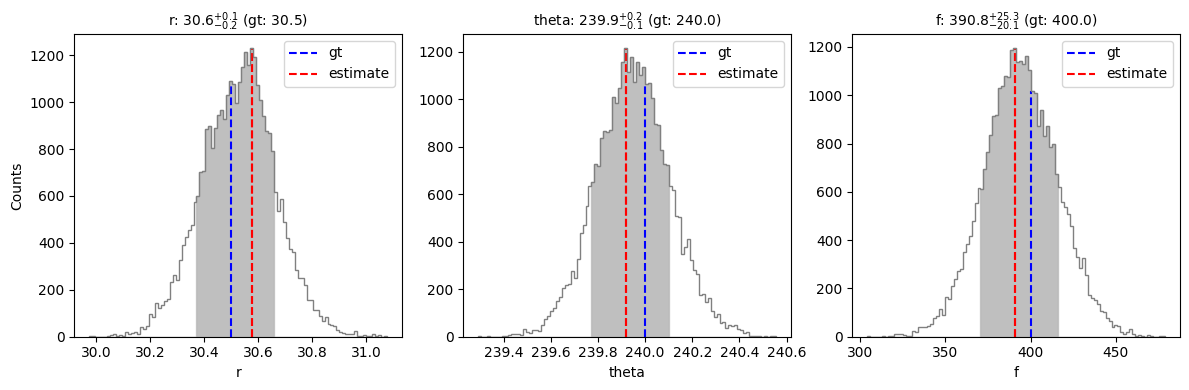

In [41]:
val_max, conf = confidence(isamples_flat, cfd=68, gaussian_fit=False, verbose=True, save=False, 
                           gt=gt, ndig=1, title=True)

Using the `confidence` function with the `gaussian_fit=True` option, it is possible to fit a Gaussian to the posterior distribution of each parameter, and infer associated uncertainty values.

percentage for r: 69.79202279202278%
percentage for theta: 69.02279202279202%
percentage for f: 68.94017094017094%


Confidence intervals:
r: 30.57489764243517 [-0.20421878422770945,0.08279139901123145]
theta: 239.91771004343246 [-0.14527599962792692,0.18317408648738365]
f: 390.7650582608513 [-20.054061636888093,25.285555976945886]

Gaussian fit results:
r: 30.525747462344565 +-0.13676103149725966
theta: 239.94793373875024 +-0.15744912409220196
f: 394.1338634773366 +-21.669634439677626


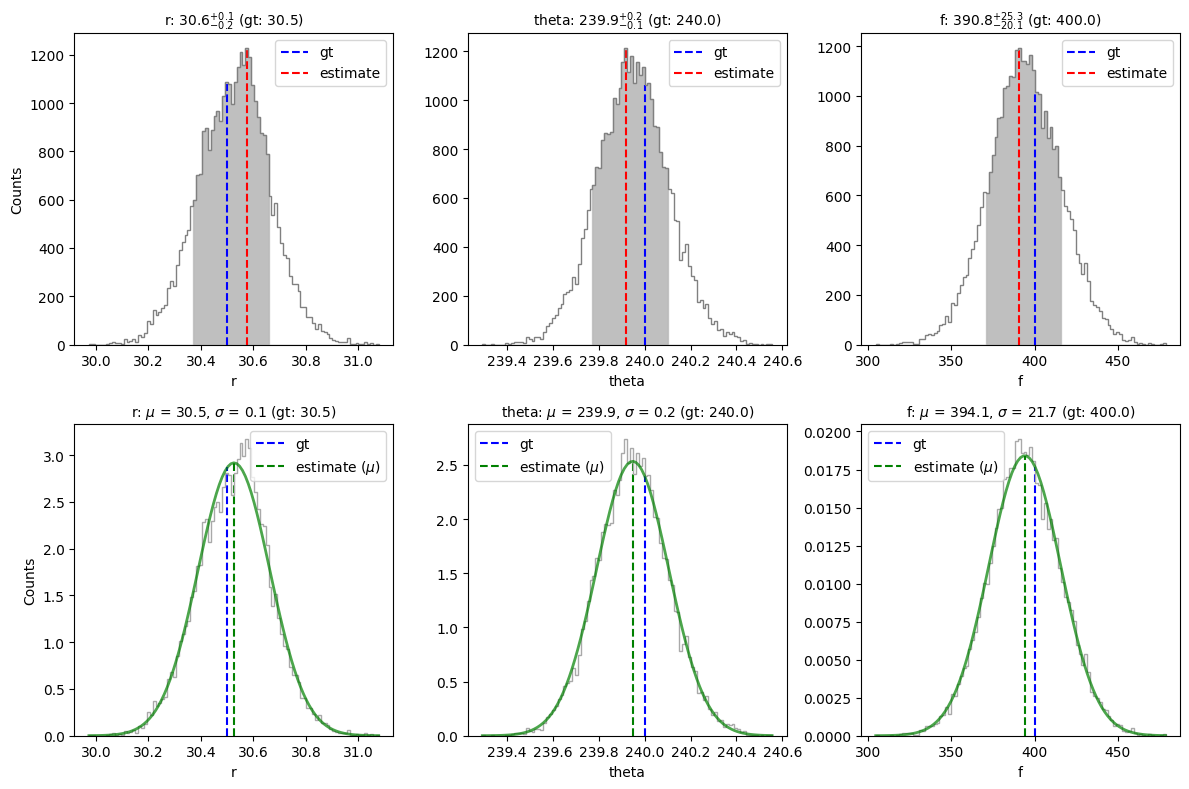

In [42]:
mu, sigma = confidence(isamples_flat, cfd=68, gaussian_fit=True, verbose=True, save=False, 
                       gt=gt, ndig=1, title=True)

It is recommended to report the results as confidence intervals (i.e. with possibly asymmetric uncertainties) as long as the bin interval is small enough. Here, we also fitted the residual posterior distribution of each parameter to a Gaussian distribution (this shape is the expected one if the noise has been well whitened, but is not necessarily guaranteed at all separations depending on the adopted $n_{\rm pc}$). In case, these distributions look Gaussian, the inferred $\sigma$ value may be a more accurate uncertainty value for the different parameters.

We can see that the confidence intervals inferred by NEGFC for the different parameters encompass the ground truth values used for injection (in particular for the flux). 

Note that depending on your choice of `mu_sigma`, you may have to calculate separately another source of uncertainty. Indeed, with the original expression for $\chi^2$ (Wertz et al. 2017; `mu_sigma=False`), only the uncertainty associated to *photon noise* was reflected in the MCMC results. With the new expression (`mu_sigma=True`), the $\chi^2$ expression also takes into account the *residual speckle noise* at the radial separation of the companion candidate. Our tests suggest that similar final uncertainties can be obtained in either of these 2 ways:  

- the uncertainties obtained with MCMC when setting `mu_sigma=True`;  
- the uncertainties obtained by combining quadratically the uncertainties obtained with MCMC (setting `mu_sigma=False` and `fm = 'sum'`), and the residual speckle uncertainties inferred as in [Sec. 5.3.4](#5.3.4.-Residual-speckle-uncertainty) (Wertz et al. 2017).  

### 5.3.4. Residual speckle uncertainty

**Only needed if using `mu_sigma=False` in your call to mcmc_negfc_sampling!**

Residual speckle noise can also bias the best parameter estimates found for the companion (if not taken into account in the MCMC).
To evaluate the uncertainty associated to this additional source of noise, it is recommended to inject a large number of fake companions at the same radius and flux as estimated for the true companion but different azimuths, and then estimate their parameters using simplex-NEGFC. The distribution of differences with respect to injected parameters can then give us an idea of the *residual speckle noise uncertainty*. This is done in VIP with the `speckle_noise_uncertainty` function (see also Sec. 3.3 in Wertz et al. 2017 for more details).

Let's use the planet parameters inferred by the MCMC-NEGFC algorithm:

In [43]:
pl_par = (val_max['r'],val_max['theta'],val_max['f'])
pl_par

(30.57489764243517, 239.91771004343246, 390.7650582608513)


#######################################################
###            SPECKLE NOISE DETERMINATION          ###
#######################################################

Number of steps: 360

Process is running for angle: 0.00
Process is running for angle: 18.00
Process is running for angle: 36.00
Process is running for angle: 54.00
Process is running for angle: 72.00
Process is running for angle: 1.00
Process is running for angle: 37.00
Process is running for angle: 19.00
Process is running for angle: 73.00
Process is running for angle: 55.00
Process is running for angle: 38.00
Process is running for angle: 2.00
Process is running for angle: 20.00
Process is running for angle: 74.00
Process is running for angle: 56.00
Process is running for angle: 39.00
Process is running for angle: 3.00
Process is running for angle: 75.00
Process is running for angle: 21.00
Process is running for angle: 40.00
Process is running for angle: 57.00
Process is running for angle: 4.00
Process is running fo



Confidence intervals:
r: -0.024134815678862734 [-0.07158544342526864,0.07912075325950745]
theta: 0.00192083834674861 [-0.07318592808734081,0.07318592808734081]
f: -0.6380453955114689 [-10.4832251622406,10.4832251622406]

Gaussian fit results:
r: -0.005339318215964717 +-0.05274467671476413
theta: -0.0007472801152008336 +-0.07271145216585939
f: -0.001480924817492103 +-10.612436375468306


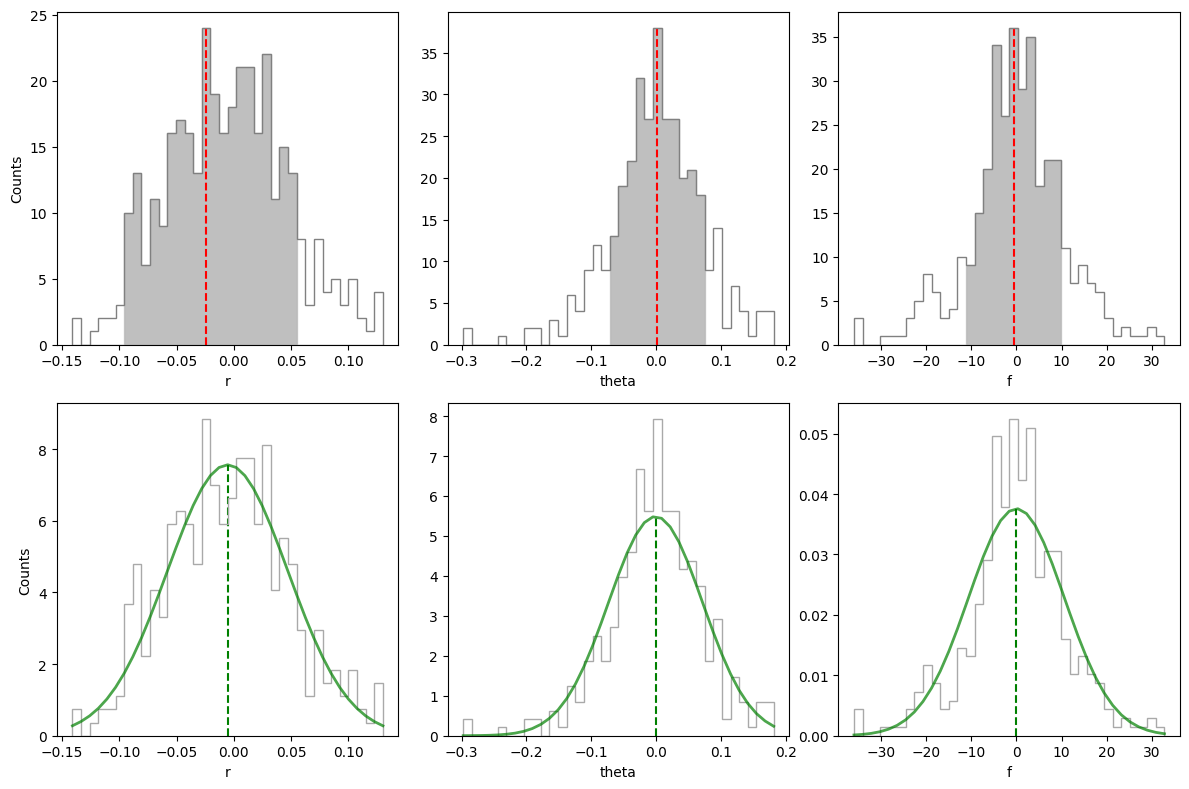

In [44]:
algo_options={'ncomp':opt_npc_ann, 'annulus_width':4*fwhm_naco, 'imlib':imlib_rot, 
              'interpolation':interpolation}
speckle_res = speckle_noise_uncertainty(cubefc, pl_par, np.linspace(0,359,360), angs, pca_annulus, 
                                        psfn, fwhm_naco, aperture_radius=2, fmerit='sum', 
                                        algo_options=algo_options, transmission=None, mu_sigma=None, 
                                        wedge=None, weights=None, force_rPA=False, nproc=None, 
                                        simplex_options=None, bins=None, save=False, output=None, 
                                        verbose=True, full_output=True, plot=True)

Again, if you wish to write the result (to avoid having to run the previous box again), just set `write=True`. This will pickle the result:

In [45]:
write=False

if write:
    output = {'speckle_res':speckle_res}
    with open('../datasets/my_speckle_residuals_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

Load pickled results from disk:

In [46]:
with open('../datasets/speckle_residuals_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    sp_unc_result = myPickler.load()

print(sp_unc_result.keys())

speckle_res = sp_unc_result['speckle_res']
sp_unc, mean_dev, p_simplex, offset, chi2, nit, success = speckle_res

dict_keys(['speckle_res'])


The speckle uncertainty associated to each parameter is contained in `sp_unc` which corresponds to the 1$\sigma$ width of a Gaussian distribution fitted to the `offset` distribution (i.e. the differences with respect to injected ground truths):

In [47]:
sp_unc

array([ 0.05350939,  0.07376633, 10.64773837])

For comparison, the uncertainties found by the MCMC procedure were:

In [48]:
sigma

array([ 0.13676103,  0.15744912, 21.66963444])

### 5.3.5. Final uncertainties

The final uncertainties on the planet parameters should include both **statistical** and **systematic** uncertainties. 
The former include both the *photon noise* and *residual speckle noise* uncertainties discussed above. 
The latter include both the uncertainty on the *star location* (which may be non-negligible when using a coronagraph) and *instrumental calibration errors*, including:

- the uncertainty on the plate scale (for $r$, when converting to angular separation) - note that it is proportional to the radial separation itself;
- the uncertainty on the PA of true north (for $\theta$).

The uncertainty on the star location is of the order of 0.3px in individual NACO+AGPM images (this is the typical precision by manual recentering during the observation). Given the shift plots in `Tutorial 2`, it appears the autocorrelation timescale is of the order of ~5 frames. Therefore, considering that there are 61 frames in the datacube, the uncertainty on the star location in the final combined image must be roughly:

In [49]:
cen_unc_indiv = 0.3 #px
cen_unc = cen_unc_indiv/np.sqrt(61/5) #px
cen_unc

0.08588975014708022

The latter can be translated into an uncertainty on $\theta$ by division by the radial separation of the companion. The stellar centering uncertainties on each planet parameter can thus be expressed as:

In [50]:
star_unc = np.array([cen_unc*pxscale_naco, 
                     np.rad2deg(cen_unc/val_max['r']), 
                     0]) # uncertainty on each of the 3 parameters due to stellar centering

where the multiplication by `pxscale_naco` has converted the radial separation in arcsec.

For the instrumental calibration errors, we adopt the values quoted in Absil et al. (2013). Note that the uncertainty related to the plate scale is directly proportional to the radial separation of the companion.

In [51]:
dr_unc = 0.00004 # plate scale uncertainty in arcsec per px
tn_unc = 0.09    # deg
syst_unc = np.array([val_max['r']*dr_unc, 
                     tn_unc, 
                     0])

The final uncertainties are then the different sources of uncertainty added quadratically - after conversion of the radial separation to arcsec:

In [52]:
sigma[0] *= pxscale_naco
sp_unc[0] *= pxscale_naco

if mu_sigma:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(star_unc,2) + np.power(syst_unc,2))
else:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(sp_unc,2) + np.power(star_unc,2) + np.power(syst_unc,2))

In [53]:
msg = "The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: \n"
msg+= "r = {:.2f}+-{:.2f} mas (GT: {:.2f} mas), \n"
msg+= "PA = {:.2f}+-{:.2f} deg (GT: {:.2f} deg) \n"
msg+= "f = {:.2f}+-{:.2f} ADUs (GT: {:.2f} ADUs)"
print(msg.format(val_max['r']*pxscale_naco*1000, final_unc[0]*1000, rad_fc*pxscale_naco*1000,
                 val_max['theta'], final_unc[1], theta_fc,
                 val_max['f'], final_unc[2], flux_fc))

The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: 
r = 831.33+-4.56 mas (GT: 829.29 mas), 
PA = 239.92+-0.24 deg (GT: 240.00 deg) 
f = 390.77+-21.67 ADUs (GT: 400.00 ADUs)


Let's consider the Gaussian fit instead:

In [54]:
msg = "Considering a Gaussian fit to the posterior distributions, the final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: \n"
msg+= "r = {:.2f}+-{:.2f} mas (GT: {:.2f} mas), \n"
msg+= "PA = {:.2f}+-{:.2f} deg (GT: {:.2f} deg) \n"
msg+= "f = {:.2f}+-{:.2f} ADUs (GT: {:.2f} ADUs)"
print(msg.format(mu[0]*pxscale_naco*1000, final_unc[0]*1000, rad_fc*pxscale_naco*1000,
                 mu[1], final_unc[1], theta_fc,
                 mu[2], final_unc[2], flux_fc))

Considering a Gaussian fit to the posterior distributions, the final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: 
r = 830.00+-4.56 mas (GT: 829.29 mas), 
PA = 239.95+-0.24 deg (GT: 240.00 deg) 
f = 394.13+-21.67 ADUs (GT: 400.00 ADUs)
